## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
from google.colab import drive
drive.mount('../content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ../content/gdrive


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
import os
os.chdir('/content/gdrive/My Drive/R9 External/')
path = '.'

In [0]:
pwd

'/content/gdrive/My Drive/R9 External'

In [0]:
project_path = '/content/gdrive/My Drive/R9 External/'
project_path

'/content/gdrive/My Drive/R9 External/'

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

In [0]:
path_train

'/content/gdrive/My Drive/R9 External/train/'

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
mkdir train

In [0]:
ls

data/  data.zip  R9_External_Lab_Questions-1.ipynb  train/  train.zip


# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')


In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
os.listdir(path_train)

['images', 'masks']

In [0]:
imagelist = os.listdir(path_train+'/images/')
masklist = os.listdir(path_train+'/masks/')

In [0]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

9ae45b19d3.png
9ae45b19d3.png
e8757626a1.png
e8757626a1.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


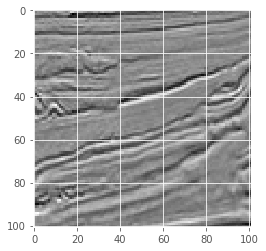

In [0]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.imread(path_train+'/images/'+imagelist[-1]))

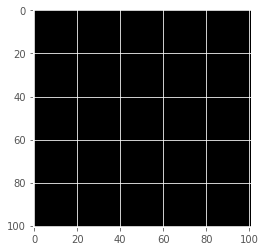

In [0]:
plt.imshow(cv2.imread(path_train+'/masks/'+masklist[-1]))

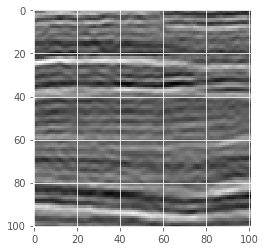

In [0]:
plt.imshow(cv2.imread(path_train+'/images/'+imagelist[10]))

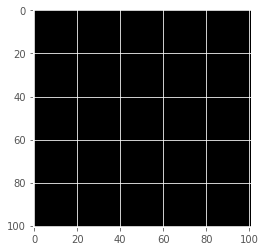

In [0]:
plt.imshow(cv2.imread(path_train+'/masks/'+masklist[10]))

In [0]:
cv2.imread(path_train+'/masks/'+masklist[10]).shape

(101, 101, 3)

In [0]:
image_10 = cv2.imread(path_train+'/masks/'+masklist[10])

In [0]:
image_resize_10 = cv2.resize(image_10,(128,128))

In [0]:
image_resize_10.shape

(128, 128, 3)

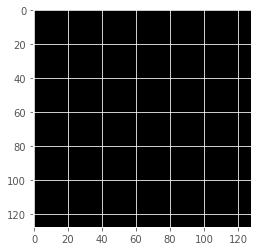

In [0]:
plt.imshow(image_resize_10)

In [0]:
image_resize_10.squeeze()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
import numpy as np
from PIL import Image

In [0]:
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 3)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), 16, 16, 3)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        #print(n)
        k = imagelist.index(n)
        ##Add image_path
        image_path =  os.path.join(path_train+'/images/')
        ##Add mask_path
        mask_path = os.path.join(path_train+'/masks/')                                                           
        
        # Load images and resize to (128,128,1)
        img = Image.open(image_path+n)
        img = img.resize((128,128))
        resized_img = np.reshape(img.convert('L'), (128,128,1))
        #img = cv2.imread(image_path+n)
        #resized_img = cv2.resize(img,(128,128))
        #print(resized_img.shape)
        
        # Load masks and resize to (128,128,1)
        msk = Image.open(mask_path+n)
        msk = msk.resize((16,16))
        resized_mask = np.reshape(msk.convert('L'), (16,16,1))
        
        #msk = cv2.imread(mask_path+n)
        #resized_mask = cv2.resize(msk,(128,128))
        #print(resized_mask.shape)
        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        #X[k] = resized_img.squeeze()/255
        y[k] = resized_mask/255
    print('Done!')
    return X,y
    '''if train:
        return X, y
    else:
        return X'''
    
X, y = get_data()

Done!


In [0]:
X.shape

(4000, 128, 128, 3)

In [0]:
y.shape

(4000, 16, 16, 3)

In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [0]:
X_train.shape

(3400, 128, 128, 3)

In [0]:
X_valid.shape

(600, 128, 128, 3)

In [0]:
y_train.shape

(3400, 16, 16, 3)

In [0]:
y_valid.shape

(600, 16, 16, 3)

3198


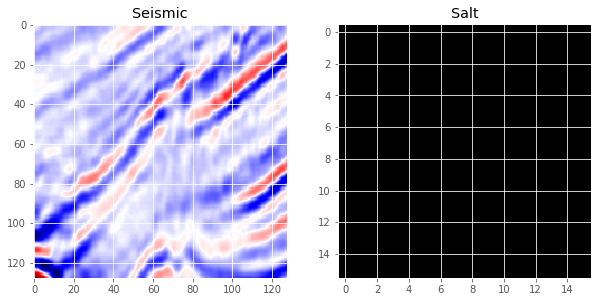

In [0]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
print(ix)
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

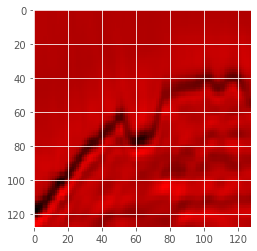

In [0]:
plt.imshow(X[2140])

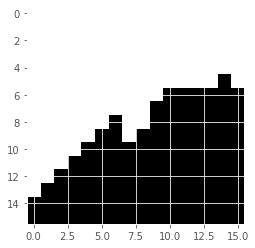

In [0]:
plt.imshow(y[2140])

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
project_path = '/content/gdrive/My Drive/R9 External/'
project_path

'/content/gdrive/My Drive/R9 External/'

In [0]:
import os
os.chdir(project_path)

In [0]:
mkdir data

In [0]:
ls

data/  data.zip  R9_External_Lab_Questions-1.ipynb  train/  train.zip


In [0]:
import os
os.listdir(project_path)

['train.zip', 'data.zip', 'train', 'R9_External_Lab_Questions-1.ipynb', 'data']

In [0]:
from zipfile import ZipFile

with ZipFile(project_path + 'data.zip', 'r') as zf:
  zf.extractall('data/')

### Import Keras and other libraries

In [0]:
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
import glob
ds_path = project_path+'data/data/'
fileList = glob.glob(ds_path+'*.txt')
fileList

['/content/gdrive/My Drive/R9 External/data/data/For Love of the King.txt',
 '/content/gdrive/My Drive/R9 External/data/data/Salomé A tragedy in one act.txt',
 '/content/gdrive/My Drive/R9 External/data/data/Impressions of America.txt',
 '/content/gdrive/My Drive/R9 External/data/data/The Canterville Ghost.txt',
 '/content/gdrive/My Drive/R9 External/data/data/A House of Pomegranates.txt',
 '/content/gdrive/My Drive/R9 External/data/data/Miscellaneous Aphorisms_ The Soul of Man.txt',
 '/content/gdrive/My Drive/R9 External/data/data/A Woman of No Importance a play.txt',
 '/content/gdrive/My Drive/R9 External/data/data/Essays and Lectures.txt',
 '/content/gdrive/My Drive/R9 External/data/data/The Happy Prince and other tales.txt',
 '/content/gdrive/My Drive/R9 External/data/data/Rose Leaf and Apple Leaf.txt',
 '/content/gdrive/My Drive/R9 External/data/data/Vera or, The Nihilists.txt',
 '/content/gdrive/My Drive/R9 External/data/data/Lord Arthur Savile_s Crime.txt',
 '/content/gdrive/My

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
codetext = []
bookranges = []
for file in fileList:
    text = open(file, "r")
    start = len(codetext)
    codetext.append(text.read())
    end = len(codetext)
    bookranges.append({"start": start, "end": end, "name": file.rsplit("/", 1)[-1]})
    text.close()

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(codetext)

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [0]:
for i, sequence in enumerate(X_train[:2]):
    text = []
#     print(i, sequence)
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: room in algernon's flat in half moon street the room is luxuriously and artistically furnished the sound of a

Label: piano

Features: a woman of no importance a play author oscar wilde release date september 16 2014 ebook 854 this file

Label: was



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [0]:
rnn_model = Sequential()

# Embedding layer
rnn_model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
rnn_model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
rnn_model.add(Dense(64, activation='relu'))

# Dropout for regularization
rnn_model.add(Dropout(0.5))

# Output layer
rnn_model.add(Dense(num_words, activation='softmax'))

# Compile the model
rnn_model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         3283900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32839)             2134535   
Total params: 5,464,835
Trainable params: 5,464,835
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [0]:
h = rnn_model.fit(X_train, y_train, epochs = 500, batch_size = 50, 
          verbose = 1)## Train the model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/500





6510/6510 [==============================] - 22s 3ms/step - loss: 8.1832 - acc: 0.0582
Epoch 2/500
6510/6510 [==============================] - 20s 3ms/step - loss: 6.7205 - acc: 0.0608
Epoch 3/500
6510/6510 [==============================] - 20s 3ms/step - loss: 6.4523 - acc: 0.0607
Epoch 4/500
6510/6510 [==============================] - 20s 3ms/step - loss: 6.2808 - acc: 0.0616
Epoch 5/500
6510/6510 [==============================] - 20s 3ms/step - loss: 6.1395 - acc: 0.0685
Epoch 6/500
6510/6510 [==============================] - 20s 3ms/step - loss: 6.0068 - acc: 0.0699
Epoch 7/500
6510/6510 [==============================] - 20s 3ms/step - loss: 5.8781 - acc: 0.0725
Epoch 8/500
6510/6510 [==============================] - 20s 3ms/step - loss: 5.7595 - acc: 0.0777
Epoch 9/500
6510/6510 [==============================] - 20s 3ms/step - loss: 5.6444 - acc: 0.0813
Epoch 1

### Save Model

In [0]:
rnn_model.save('./data/model_500epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
rnn_save_model = load_model('/content/gdrive/My Drive/R9 External/data/model_500epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [0]:
rnn_save_model.fit(X_train, y_train, batch_size=50, epochs=500, validation_data=(X_valid,y_valid))

Train on 6510 samples, validate on 2790 samples
Epoch 1/500
6510/6510 [==============================] - 8s 1ms/step - loss: 0.3620 - acc: 0.8856 - val_loss: 9.0100 - val_acc: 0.3710
Epoch 2/500
6510/6510 [==============================] - 6s 919us/step - loss: 0.3670 - acc: 0.8814 - val_loss: 8.9958 - val_acc: 0.3692
Epoch 3/500
6510/6510 [==============================] - 6s 889us/step - loss: 0.3757 - acc: 0.8817 - val_loss: 8.9953 - val_acc: 0.3656
Epoch 4/500
6510/6510 [==============================] - 6s 857us/step - loss: 0.3707 - acc: 0.8797 - val_loss: 9.0252 - val_acc: 0.3663
Epoch 5/500
6510/6510 [==============================] - 6s 856us/step - loss: 0.3788 - acc: 0.8808 - val_loss: 9.0199 - val_acc: 0.3656
Epoch 6/500
6510/6510 [==============================] - 6s 881us/step - loss: 0.3854 - acc: 0.8788 - val_loss: 8.9970 - val_acc: 0.3695
Epoch 7/500
6510/6510 [==============================] - 6s 887us/step - loss: 0.3681 - acc: 0.8791 - val_loss: 9.0117 - val_acc: 0.

## Evaluation

In [0]:
print(rnn_save_model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(rnn_save_model.evaluate(X_valid, y_valid, batch_size = 20))

6510/6510 [==============================] - 3s 531us/step
[0.0184611381701408, 0.9930875559556319]

Model Performance: Log Loss and Accuracy on validation data
2790/2790 [==============================] - 1s 534us/step
[9.278793536634002, 0.3727598584467365]


## Generate text

In [0]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = rnn_save_model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
# print(gen_list)
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))
# print(a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Original Sequence: 
to tokio on the contrary you will stay at home and steep yourself in the work of certain japanese artists and then when you have absorbed the spirit of their style and caught their imaginative manner of vision you will go some afternoon and sit in the park or stroll


Generated Sequence: 
for as i believed to the scenes of the play act i algernon moncrieff's flat in waste paper and conceal the artist is art's aim the critic is seventh editions of shoppe 11 to de châteaudun registered at stationers' hall and protected country the blackmailing of the emperor had garden
